# Assignment 3, Group 8
Ankit Mishra, Bikash Badatya, Bhushan Kape, Ankiet Ghosh\
All members have 25% contribution.

The discretized Schrodinger Equation using 5-point stencil  is:
$$
\frac{\partial \psi_j(t)}{\partial t} =-\frac{i}{24 \Delta x^2} \left [\psi_{j+2}(t) - 16\psi_{j+1}(t) + 30\psi_{j}(t) - 16\psi_{j-1}(t) + \psi_{j-2}(t)\right ] -i V_j(t) \; \psi_j(t)
$$


To make it suitable for leapfroG integration, we need to separate the wavefunction $\psi_j(t)$ into its real and imaginary parts:
$$
\psi_j(t) = R_j(t) + i \, I_j(t).
$$

Substituion leads to the following set of coupled ODEs:
\begin{align}
\frac{dR_j}{dt} &=& a I_{j+2} - cI_{j+1} + b_j I_{j} - cI_{j-1} + a I_{j-2} \\
\frac{dI_j}{dt} &=& -a I_{j+2} + cI_{j+1} - b_j I_{j} + cI_{j-1} - a I_{j-2} \\          
\end{align}
where 
$$ a = \frac{1}{24 \Delta x^2} ~,~ b_j = \left( \frac{30}{24 \Delta x^2} + V_j \right) ~,~ c = \frac{16}{24 \Delta x^2} $$

\begin{gather}
 \begin{bmatrix} dR_0/dt \\ dR_1/dt \\ dR_2/dt \\ \vdots \\ \vdots \\ dR_N/dt \\ \end{bmatrix}
 =

  \begin{bmatrix}
   b_0  & -c  & a & \cdots & a & -c \\
   -c   & b_1 & -c & a  & \cdots & a \\
   a    & -c  & b_2 & -c & a  & \cdots  \\
   \vdots & & & &  & \vdots\\ 
   -c & a  & \cdots & a  & -c & b_N \\
   
   \end{bmatrix}
   \begin{bmatrix} I_0 \\ I_1 \\ I_2 \\ \vdots \\ \vdots \\ I_N \\ \end{bmatrix}
\end{gather}
$$\frac{d\vec{R}}{dt} = A \vec{I}$$
Similarly
$$\frac{d\vec{I}}{dt} = -A \vec{R}$$
Where $A$ is the matrix defined above.

#### Leap-Frog Integration
We then use the leap frog integration.
\begin{align}
I_j {(t + \Delta t/2)} &= I_j (t) + \left [ {dI_j}/{dt} \right ]_{R_j(t)} \times \Delta t/2  \\
R_j {(t + \Delta t)} &= R_j (t) + \left [ dR_j/dt \right ]_{I_j{(t + \Delta t/2)}} \times \Delta t \\
I_j {(t + \Delta t)} &= I_j {(t + \Delta t/2)} + \left [ dI/dt \right ]_{R_j(t + \Delta t)} \times \Delta t/2
\end{align}




**Expectation Values** \
For position:
$$\langle x \rangle = \sum_{0}^{N}\psi^\dag(x_i) x_i \psi(x_i) $$

For momentum:
$$\langle p \rangle = \int dx(R - iI) \left(-i\hbar\frac{\partial R}{\partial x} - i^2\hbar\frac{\partial R}{\partial x} \right) = \hbar \int \left( R\frac{\partial I}{\partial x} - I\frac{\partial R}{\partial x} \right) dx$$

Then we use 5-point stencil to approximate $\frac{\partial R}{\partial x}$ and $\frac{\partial I}{\partial x}$:
$$
\frac{dR}{dx}=\frac{1}{12\Delta x^2}[-R_{j+2}+8R_{j+1}-8R_{j-1}+R_{j-2}]
$$
$$
\frac{dI}{dx}=\frac{1}{12\Delta x^2}[-I_{j+2}+8I_{j+1}-8I_{j-1}+I_{j-2}]
$$

So $$\langle p \rangle = \sum_{j=0}^{N}(R_j I'_j - I_j R'_j)$$


In [237]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson as simp


In [4]:
#-- position expectation value. 
def avg_x(x, psi):
    dx = x[1]-x[0]
    xPsi = x*psi
    return np.real(simp(psi.conjugate()* xPsi, x))

#-- momentum expectation value.
def avg_P(x, R, I):
    dx = x[1] - x[0]

    #-- central difference for derivatives (assume periodic bndry for wavefunction)
    dRdx = (1.0/(12*dx))*(-(np.roll(R, 2)) +8*(np.roll(R, 1))-8*(np.roll(R,-1))+np.roll(R,-2))
    dIdx = (1.0/(12*dx))*(-(np.roll(I, 2)) +8*(np.roll(I, 1))-8*(np.roll(I,-1))+np.roll(I,-2))

    return -simp(R*dIdx - I*dRdx, x)

**Define Potential**

In [5]:
@np.vectorize
def V(x):
    return 0.5*x*x


**Define inital wave function**

In [238]:
xa , xb = -10. , 10 # left, right limit

# Define Wavefunction at t=0
sigma = 0.5
x0 = -3
k0 = 0.0

dx = 0.04
x = np.arange(xa, xb+dx, dx)
Vx = V(x)

psi0 = 1./np.sqrt(sigma * np.sqrt(2*np.pi))* np.exp( -((x-x0)**2.)/(4.*sigma**2.) + 1j*k0*x )
R = np.real(psi0)
I = np.imag(psi0)
print(f'At t=0, dx = {dx}, k0 = {k0}, <p> = {avg_P(x, R, I)}, <x> = {avg_x(x, psi0)}')


At t=0, dx = 0.04, k0 = 0.0, <p> = -0.0, <x> = -3.0000000000000004


**Plot to check correct.**

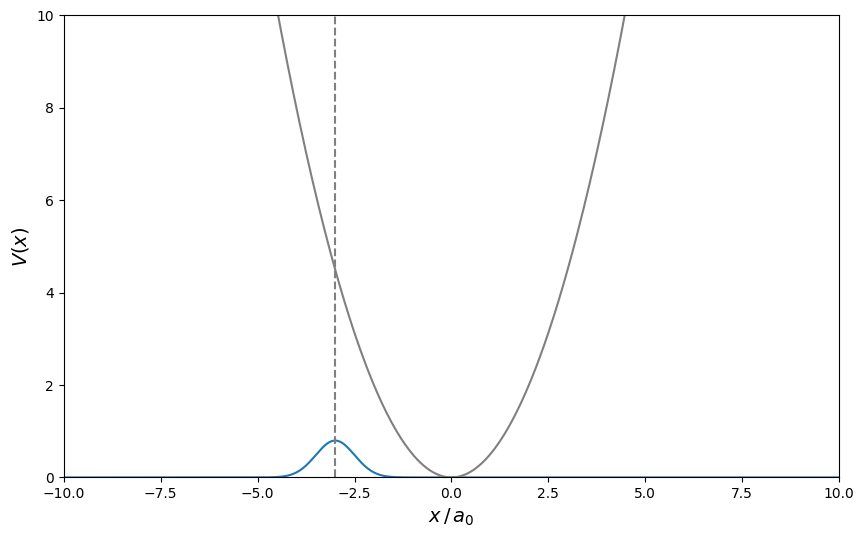

In [239]:
plt.figure(figsize=(10,6))

plt.plot(x, np.abs(psi0)**2)
plt.xlim(xa, xb)

plt.plot(x, V(x), '-', color='gray')
plt.xlabel(r'$x \, / \, a_0$', fontsize=14)
plt.ylabel(r'$V(x)$', fontsize=14)
plt.axvline(-3.0,ls='--',c='grey')
plt.xlim(xa, xb), plt.ylim(0,10)
plt.show()

**Create the $A$ matrix.**

In [240]:
N = len(x)
A = np.zeros((N,N))
a = 1./(24.*dx*dx)
c = 16./(24.*dx*dx)

for i in range(-1,N-1):
    A[i,i] = 30./(24.*dx*dx)+ V(x[i])
    A[i+1,i-1], A[i-1, i+1] = a, a
    A[i+1,i], A[i, i+1] = -c,-c



## Leapfrog

In [57]:
dt = 0.5*(dx**2)
Nt =  25000      # time-steps to integrate over
print('dx = %.4e, dt = %.4e, integrating for %d time=steps'%(dx, dt, Nt))

tfrac = 0.04
Nplots = int(1./tfrac)
psi_t = np.empty((Nplots, len(x)), dtype='complex')
psi_all=np.empty((Nt,len(x)),dtype="complex")
j = 0
for i in range(1, Nt+1):
    psi_all[i-1,:]=R +1j*I 
    R_half = R + np.matmul(A, I) * (dt/2.)
    I = I - np.matmul( A , R_half ) * dt
    R = R_half +  np.matmul(A,I) *(dt/2.)

    if ((i % int(tfrac*Nt)) == 0):
        print(i)
        print('Storing snapshot %2d/%2d of the complex wavefunction '%(j+1, Nplots))
        psi_t[j,:] = R + 1j*I
        j = j+1 #-- prepare for next snapshot

#-- add psi0 to the top of the stack of \psi(t)
psi_t = np.vstack((psi0, psi_t))

dx = 4.0000e-02, dt = 8.0000e-04, integrating for 25000 time=steps
1000
Storing snapshot  1/25 of the complex wavefunction 
2000
Storing snapshot  2/25 of the complex wavefunction 
3000
Storing snapshot  3/25 of the complex wavefunction 
4000
Storing snapshot  4/25 of the complex wavefunction 
5000
Storing snapshot  5/25 of the complex wavefunction 
6000
Storing snapshot  6/25 of the complex wavefunction 
7000
Storing snapshot  7/25 of the complex wavefunction 
8000
Storing snapshot  8/25 of the complex wavefunction 
9000
Storing snapshot  9/25 of the complex wavefunction 
10000
Storing snapshot 10/25 of the complex wavefunction 
11000
Storing snapshot 11/25 of the complex wavefunction 
12000
Storing snapshot 12/25 of the complex wavefunction 
13000
Storing snapshot 13/25 of the complex wavefunction 
14000
Storing snapshot 14/25 of the complex wavefunction 
15000
Storing snapshot 15/25 of the complex wavefunction 
16000
Storing snapshot 16/25 of the complex wavefunction 
17000
Storing 

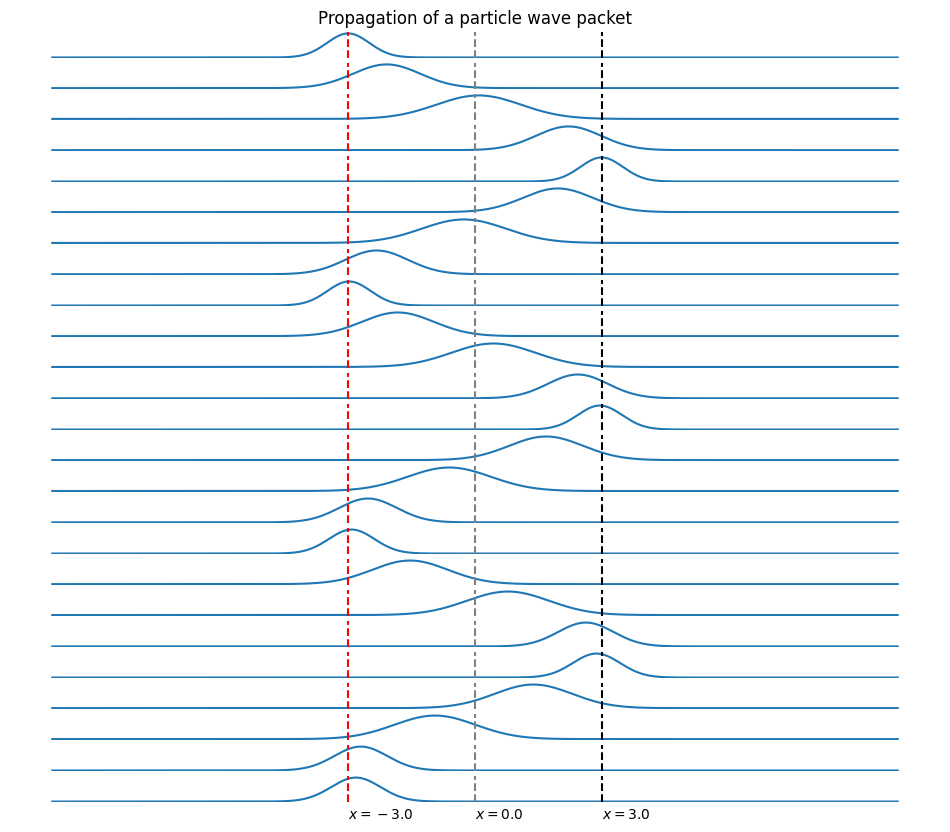

In [69]:
#-- Plot the wavefunctions psi(x, t) recorded at different instances
psi_array=[]
plt.figure(figsize=(12,10))

for j in range(Nplots):
    ax = plt.subplot(Nplots, 1, j+1)
    
    #-- remove all axis
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)
    ax.set_ylim(-0.02, 1.05*np.max(np.abs(psi_t[j,:])**2))
    #ax.set_ylim(-0.02, 1.05*np.max(np.abs(psi0)**2))
    
    #-- set the title for the first subplot
    if (j==0):
        plt.title('Propagation of a particle wave packet')
    psi_array.append(psi_t)
    #-- plot |psi(t)|^2
    ax.plot(x, np.abs(psi_t[j,:])**2)

    #-- mark the position of the cliff
    ax.axvline(-3, ls='--', color='red')
    ax.axvline(0.0, ls='--', color='gray')
    ax.axvline(3, ls='--', color='k')

plt.text(-3,-0.5,'$x=-3.0$')
plt.text(0,-0.5,'$x= 0.0$')
plt.text(3,-0.5,'$x= 3.0$')
plt.show()
# print(psi_array)

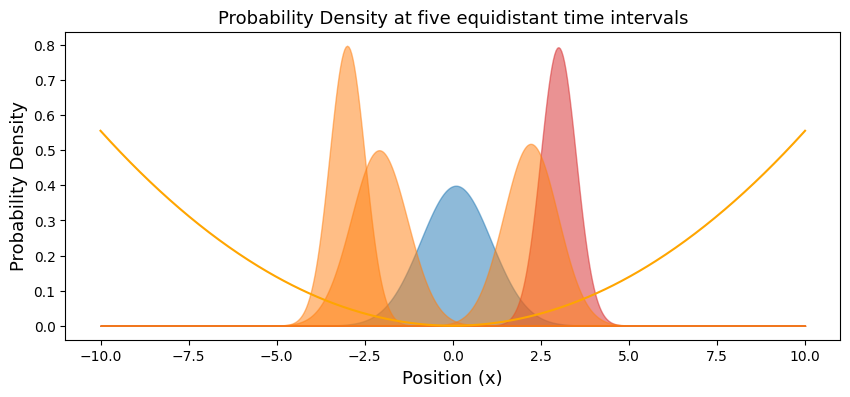

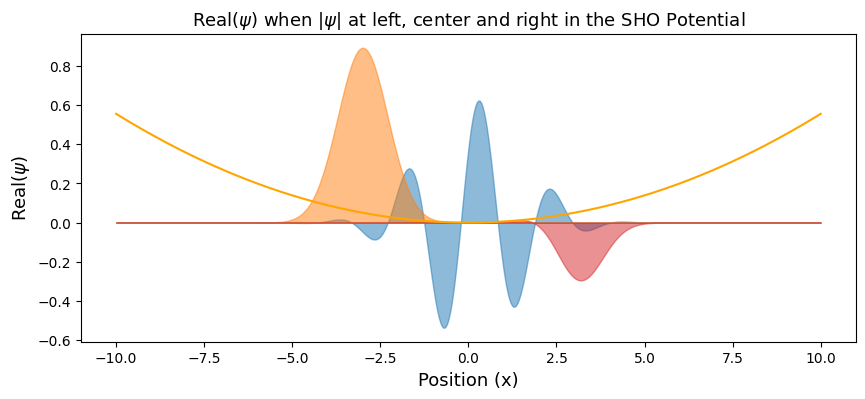

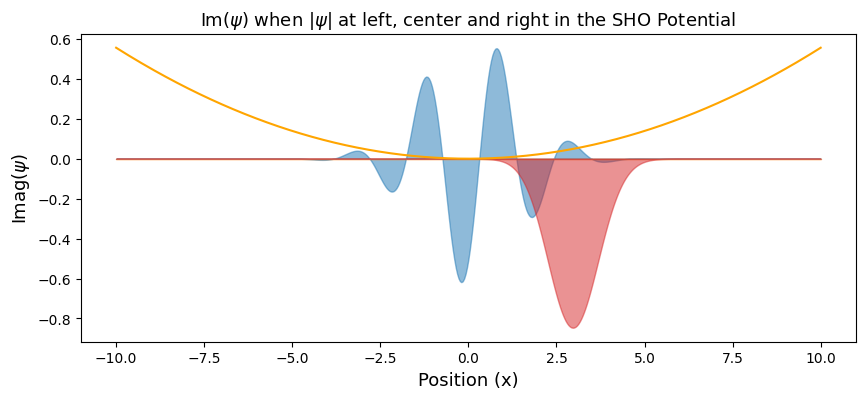

In [195]:
# print(len(psi_t))
plt.figure(figsize=(10, 4))
#-- Brightness
B=0.5
#-- Fraction value
F=90
j = 0 # left
i = 2000 # center
k = 4000  # right
plt.plot(x, V(x)/F, ls="-", color='#ffa500')
plt.fill_between(x, 0, np.abs(psi_all[i])**2,color="C0",alpha=B)
plt.fill_between(x, 0, np.abs(psi_all[j])**2,color="C1",alpha=B)
plt.fill_between(x, 0, np.abs(psi_all[k])**2,color="C3",alpha=B)
plt.fill_between(x, 0, np.abs(psi_all[1000])**2,color="C1",alpha=B)
plt.fill_between(x, 0, np.abs(psi_all[3000])**2,color="C1",alpha=B)
plt.xlabel('Position (x)',fontsize=13)
plt.ylabel('Probability Density',fontsize=13)
plt.title('Probability Density at five equidistant time intervals',fontsize=13)
# plt.show()





plt.figure(figsize=(10, 4))
plt.plot(x, V(x)/F, ls="-", color='#ffa500')
plt.fill_between(x, 0, np.real(psi_all[i]),color="C0",alpha=B)
plt.fill_between(x, 0, np.real(psi_all[j]),color="C1",alpha=B)
plt.fill_between(x, 0, np.real(psi_all[k]),color="C3",alpha=B)
# plt.fill_between(x, 0, np.real(psi_all[]),color="blue",alpha=B)
# plt.fill_between(x, 0, np.real(psi_all[7]),color="blue",alpha=B)
# plt.fill_between(x, 0, np.real(psi_t[8]),color="#ffa500",alpha=B)
# plt.fill_between(x, 0, np.real(psi_t[9]),color="blue",alpha=B)
plt.xlabel('Position (x)',fontsize=13)
plt.ylabel('Real($ \psi $)',fontsize=13)
plt.title('Real($ \psi $) when |$\psi$| at left, center and right in the SHO Potential',fontsize=13)
plt.show()





plt.figure(figsize=(10, 4))
plt.plot(x, V(x)/F, ls="-", color='#ffa500')
plt.fill_between(x, 0, np.imag(psi_all[i]),color='C0',alpha=B)
plt.fill_between(x, 0, np.imag(psi_all[j]),color="C1",alpha=B)
plt.fill_between(x, 0, np.imag(psi_all[k]),color="C3",alpha=B)
# plt.fill_between(x, 0, np.imag(psi_t[8]),color='blue',alpha=B)
# plt.fill_between(x, 0, np.imag(psi_t[9]),color='blue',alpha=B)
plt.xlabel('Position (x)',fontsize=13)
plt.ylabel('Imag($ \psi $)',fontsize=13)
plt.title('Im($ \psi $) when |$\psi$| at left, center and right in the SHO Potential',fontsize=13)
plt.show()


* We note that when $|\psi|$ is peaked at left, the imaginary part has vanished.

In [196]:
t_array = np.linspace(0,dt*(Nt+1),Nt)
x_exp = np.zeros(Nt)
p_exp = np.zeros(Nt)
pdf_max = np.zeros(Nt)

for i in range(Nt):
    RR , II = np.real(psi_all[i,:]), np.imag(psi_all[i,:])
    # norm = simp(np.abs(psi_t[j,:])**2, x)
    x_exp[i] = avg_x(x,psi_all[i,:])
    p_exp[i] = avg_P(x, RR, II)
    pdf_max[i] = np.max(RR*RR + II*II)

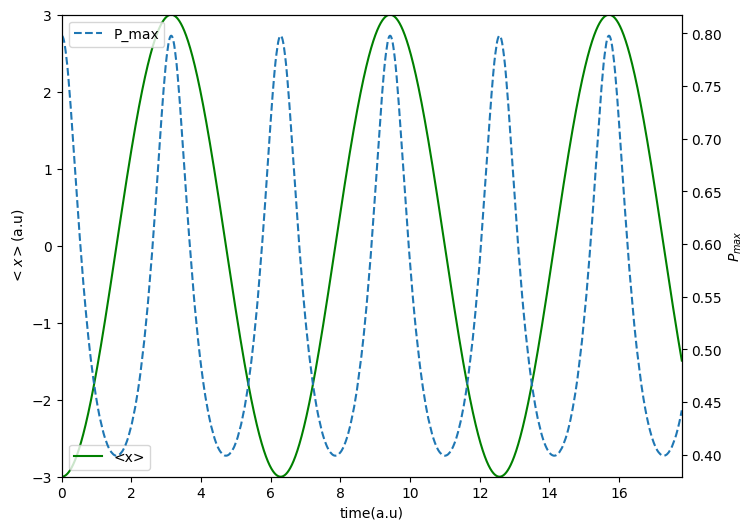

In [197]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.set_xlabel('time(a.u)')
ax1.set_ylabel('$<x>$(a.u)', )
ax1.plot(t_array,x_exp,label='<x>',c='green')
plt.ylim(-3.0,3.0), plt.xlim(0,17.8),
plt.legend(loc='lower left')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.text(13,1.8,"$p_{max}$",color="blue")

ax2 = ax1.twinx()
ax2.set_ylabel('$P_{max}$')
ax2.plot(t_array,pdf_max,label='P_max',ls='--')
# ax2.tick_params(axis='y', labelcolor='red')
# ax2.text(4.0,0.70,"$<x>$",color="red")
# plt.ylim(0.,1.2)
# fig.tight_layout()
plt.legend()
plt.show()

* We note that the $|\psi|^2$ peaks whenever the $\langle x \rangle = \pm 3.0 ~ a.u $ as the wavefunction gets squished and |$P_{max}$| increases. 

## Ehrenfest Theorem

* We know that $V(x) = x^2 / 2 \implies dV/dx = x$.
* To verify Ehrenfest theorem we need to check if $$\frac{d\langle p \rangle}{dt}\stackrel{?}{=} - \langle x \rangle$$

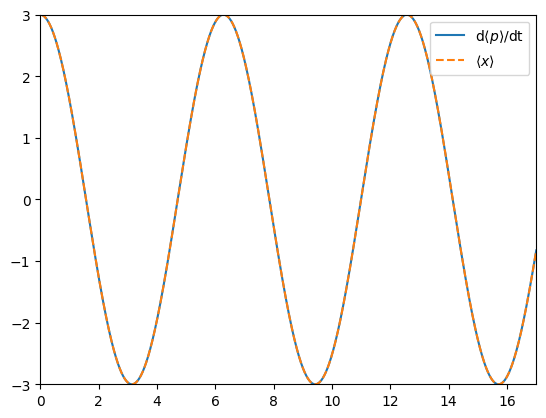

In [236]:
# Find Derivative of expectation values 
p_dash = (np.roll(p_exp,-1) - p_exp)/dt
plt.plot(t_array,p_dash,label=r'd$\langle p \rangle$/dt')
plt.plot(t_array,-x_exp,ls='--' , label=r'$\langle x \rangle$')
plt.xlim(0,17),plt.ylim(-3,3)
plt.legend()

* So we see that the Erhenfest theorem is satisfied.